# 2.1 Data Acquisition
The dataset used in this study originates from a community-driven effort to collect and analyze battle data from the game Clash Royale on kaggle. The collection spanned an entire season, from early December 2020 until the conclusion of Season 18.

The dataset includes approximately 37.9 million unique ladder battles, extracted from a pool of over 300,000 clans.

Three primary datasets were utilized in this study:
\begin{itemize}
    \item \textbf{BattlesStaging\_01012021\_WL\_tagged.csv}: A comprehensive log of individual battles, including player decks, battle outcomes, and metadata.
    \item \textbf{CardMasterListSeason18\_12082020.csv}: A reference file mapping card IDs to their names, attributes, and in-game properties.
    \item \textbf{Wincons.csv}: A dataset containing cards that are considered as game changers that could cause a player to win.
\end{itemize}

# 2.1.1 Data Structure (DeckStructureImage.jpeg)
The acquired data is structured across multiple files, each contributing distinct yet interconnected information necessary for understanding battle dynamics, card performance, and strategic interactions.

By linking these datasets through the \textbf{Card ID}, we can derive meaningful insights into deck effectiveness and strategic synergies. Specifically:

Each player's deck in \texttt{BattlesStaging\_01012021\_WL\_tagged.csv} is represented as a long binary vector. This vector encodes the presence or absence of specific cards from \texttt{CardMasterListSeason18\_12082020.csv}. Each entry in the vector corresponds to a unique \textbf{Card ID} from the master list, where: a value of 1 indicates the presence of a card corresponding to that index and 0 means its absence.


Since each deck consists of 8 cards from the entire pool, most entries in the binary vector are zeroes, making it a sparse representation. This structure allows for efficient comparisons between decks and enables further analysis, such as identifying common, rare card combinations, computing similarity metrics between decks, and assessing the combined strength of a deck or its synergy.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import shutil
import projcore as pc
from sklearn.impute import KNNImputer
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity
import math

sns.set(style="whitegrid")

In [ ]:
source_dir = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(), 'data')
IMG_DIR = os.path.join(os.getcwd(), 'images')

if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)
    print(f"Created directory: {IMG_DIR}")
else:
    print(f"Image directory already exists: {IMG_DIR}")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    pc.download_kaggle_datasets()
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.csv'):
            full_file_name = os.path.join(source_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, DATA_DIR)
                print(f"Moved: {full_file_name} to {DATA_DIR}")
else:
    print(f"Data directory already exists: {DATA_DIR}")

Data directory already exists: c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\data


In [3]:
def load_data(data_dir=DATA_DIR):
    """Load all datasets."""
    battles_df = pd.read_csv(os.path.join(data_dir, 'BattlesStaging_01012021_WL_tagged.csv'))
    # clash_royal_data = pd.read_csv(os.path.join(data_dir, 'clash_royal_data.csv'))
    card_master_list = pd.read_csv(os.path.join(data_dir, 'CardMasterListSeason18_12082020.csv'))
    wincons = pd.read_csv(os.path.join(data_dir, 'Wincons.csv'))
    
    mapping = {
        'battles_df': battles_df,
        # 'clash_royal_data': clash_royal_data,
        'card_master_list': card_master_list,
        'wincons': wincons
    }
    
    return mapping

In [4]:
# load the actual data
datasets_mapping = load_data()
battles_df = datasets_mapping['battles_df']
# clash_royal_data = datasets_mapping['clash_royal_data']
card_master_list = datasets_mapping['card_master_list']
wincons = datasets_mapping['wincons']

In [ ]:
battles_df = pc.feature_preprocessing(battles_df, wincons)

c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\projcore.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battles_df[["normalized_" + feature for feature in features_to_normalize]] = scaler.fit_transform(battles_df[features_to_normalize]) + 1
c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\projcore.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battles_df[["normalized_" + feature for feature in features_to_normalize]] = scaler.fit_transform(battles_df[features_to_normalize]) + 1
c:\Users

In [10]:
high_win_rate_probability = battles_df['winner.high_win_rate'].mean()
k = 771 # adjustable parameter
sample_size = math.ceil(k / high_win_rate_probability)
print(f"High win rate probability: {high_win_rate_probability}")

High win rate probability: 0.35521905735404175


# BEGIN PROBABILITY TEST

In [ ]:
new_battle_df = battles_df.copy()
deck_appearances = new_battle_df['winner.card_set'].value_counts().copy()
new_battle_df['appearances'] = new_battle_df['winner.card_set'].map(deck_appearances)

print(new_battle_df.shape)

appearance_theshold = 10
filtered_df = new_battle_df[new_battle_df['appearances'] >= appearance_theshold]
high_win_rate_probability_filtered = filtered_df['winner.high_win_rate'].mean()

print(f"High win rate probability for decks with at least {appearance_theshold} appearances: {high_win_rate_probability_filtered:.4f}")
k_n = 60
demo_sample = math.ceil(k_n / high_win_rate_probability_filtered)
print(f"Sample size for decks with at least {appearance_theshold} appearances: {demo_sample:.2f}")

(2823393, 80)
(2823393, 81)
High win rate probability for decks with at least 10 appearances: 0.0250
Sample size for decks with at least 10 appearances: 2400.00


# NOTE
- There's a very large difference here between the high probability win rates when taking into account a relatively small threshold. I believe it could be better to take into account this fact
- I will note here that for `k_n` and `k` we received a similar sample size so I didn't really rerun the code because it wouldn't have really caused a large difference.

# END PROBABILITY TEST

In [11]:
battles_df_sampled = battles_df.sample(n=sample_size, random_state=42).copy()
print(f"Number of battles after filtering: {battles_df_sampled.shape[0]}")

battles_df_sampled.head()

Number of battles after filtering: 2171


battleTime  arena.id  gameMode.id  \
372792  2021-01-01 05:24:40+00:00      13.0          0.0   
1041134 2021-01-01 16:37:28+00:00      13.0          2.0   
2016917 2021-01-01 09:19:57+00:00      13.0          2.0   
2376284 2021-01-01 15:41:32+00:00      13.0          2.0   
2055323 2021-01-01 09:59:38+00:00      13.0          2.0   

         average.startingTrophies  winner.tag  winner.startingTrophies  \
372792                     4576.0      161301                   4582.0   
1041134                    5404.5      414459                   5385.0   
2016917                    4559.5      943792                   4564.0   
2376284                    5952.5     1042757                   5955.0   
2055323                    4370.0      969243                   4367.0   

         winner.trophyChange  winner.crowns  winner.kingTowerHitPoints  \
372792                  28.0            3.0                     4824.0   
1041134                 33.0            3.0                     5832.0   
2016917                 29.0            3.0                     5304.0   
2376284                 29.0            1.0                     5832.0   
2055323                 30.0            2.0                     4519.0   

         winner.princessTowersHitPoints  ...  winner.max_card_level  \
372792                             4672  ...                    1.0   
1041134                            6568  ...                    1.0   
2016917                            4715  ...                    1.0   
2376284                            3755  ...                    1.0   
2055323                            2027  ...                    0.8   

         winner.min_card_level  winner.level_variance  winner.win_rate  \
372792                0.833333               0.013183         1.000000   
1041134               1.000000               0.000000         0.500000   
2016917               0.916667               0.005650         1.000000   
2376284               0.833333               0.014595         0.625000   
2055323               0.666667               0.014595         0.514995   

         winner.high_win_rate  winner.deck_weighted_strength  \
372792                   True                       0.886364   
1041134                 False                       1.000000   
2016917                  True                       0.931818   
2376284                 False                       0.965909   
2055323                 False                       0.761364   

         winner.elixir_score  loser.elixir_score  winner.synergy_score  \
372792              0.931164            0.855527              0.611200   
1041134             0.850760            1.000000              0.611200   
2016917             0.321701            0.389083              0.622258   
2376284             0.655275            0.566113              0.629168   
2055323             0.655275            1.000000              0.607182   

         winner.deck_final_score  
372792                  0.899289  
1041134                 0.779370  
2016917                 0.760131  
2376284                 0.747075  
2055323                 0.668322  

[5 rows x 80 columns]

In [12]:
unique_cards = sorted(set(card for deck in battles_df["winner.card_set"] for card in deck))
card_to_index = {card: i for i, card in enumerate(unique_cards)}

def deck_to_sparse_vector(deck):
    """Convert a deck into a sparse binary vector."""
    indices = [card_to_index[card] for card in deck]
    vec = np.zeros(len(unique_cards), dtype=np.uint8)
    vec[indices] = 1
    return vec

In [ ]:
selected_features = [
    'winner.card_set', "winner.tag", "winner.cards.list", "winner.win_lose_ratio_Z_score", 
    "winner.win_rate", "winner.deck_weighted_strength", "winner.rarity_diversity", 
    "winner.synergy_score", "winner.deck_final_score",
]

battles_df_sampled = (battles_df_sampled[selected_features]).copy()
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(battles_df_sampled[
    ["winner.win_lose_ratio_Z_score", "winner.win_rate", "winner.deck_weighted_strength", 
     "winner.rarity_diversity", "winner.synergy_score", "winner.deck_final_score", "winner.tag"]
])

deck_vectors = np.array([deck_to_sparse_vector(deck) for deck in battles_df_sampled["winner.card_set"]])
combined_vectors = np.hstack((deck_vectors, normalized_features))
print(deck_vectors.shape)
print(combined_vectors.shape)

(2171, 102)


# Considering different metrics to check the difference between them

# Explanation:
below, we add some plots showing the results we receive for ['hamming', 'jaccard', 'cosine'] metrics. we mainly try to find ways of capturing similarities / differences between different decks in the game such that the separation is as good as possible when considering our data representation which is made of a vector the length of all the cards in the game with 1 in the corresponding index of each card that appears in the deck and 0 otherwise.

In order to capture those similarities between decks, we thought we'd use:
1. 'Hamming' distance
2. 'cosine' distance
3. 'jaccard' distance

# FOR PAPER
Below, we present plots showing the results for the \textbf{Hamming}, \textbf{Euclidean}, \textbf{Canberra}, and \textbf{Cosine} distance metrics. Our primary objective is to quantify similarity between decks in a way that ensures meaningful separation, given our data representation. Each deck is represented as a binary vector of length equal to the total number of unique cards in the game, where a \textbf{1} appears at the index of each card present in the deck and a \textbf{0} otherwise.  

To evaluate similarity between decks, we considered the following metrics:  

\begin{enumerate}  
    \item \textbf{Hamming Distance} – This metric measures the number of positions where two binary vectors differ. In our case, it counts the number of cards that are different between two decks. Since our representation is binary and sparse, Hamming distance is an efficient and straightforward measure of deck dissimilarity. However, it does not account for deck sizes but that's not a problem for us because all decks have 8 cards.

    \item \textbf{Euclidean Distance} – This metric computes the straight-line distance between two points in high-dimensional space. In the case of binary vectors, Euclidean distance is related to Hamming distance, but it scales differently due to squaring and summation. While it provides a continuous measure of smiilarity, it may not be the most efficient for binary data, as it does not inherently exploit the sparsity of our deck representation.  

    \item \textbf{Canberra Distance} – This metric is particularly useful for sparse binary data. It calculates the weighted difference between vector components as:  

    \begin{equation}  
        d(A, B) = \sum_{i} \frac{|A_i - B_i|}{|A_i| + |B_i|}
    \end{equation}  

    Since our vectors are binary, this metric emphasizes small differences more than other distance measures, making it sensitive to minor variations between decks. However, its reliance on summing fractional differences may introduce instability when comparing decks with very few common cards.  

    \item \textbf{Cosine Distance} – This metric measures the angular difference between two vectors in high-dimensional space. For binary vectors, it simplifies to computing the dot product, effectively capturing the fraction of shared cards between two decks relative to their total deck sizes. Cosine distance is computationally efficient and useful for identifying decks that share a high proportion of cards, though it may be less sensitive to minor differences between similar decks.  
\end{enumerate}

In [ ]:
metrics = ["hamming", "cosine", "euclidean", "canberra"]
plots_mds = {}
for metric in metrics:
    pairwise_dist_metric = squareform(pdist(deck_vectors, metric=metric))
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    deck_positions_mds = mds.fit_transform(pairwise_dist_metric)
    plots_mds[metric] = deck_positions_mds

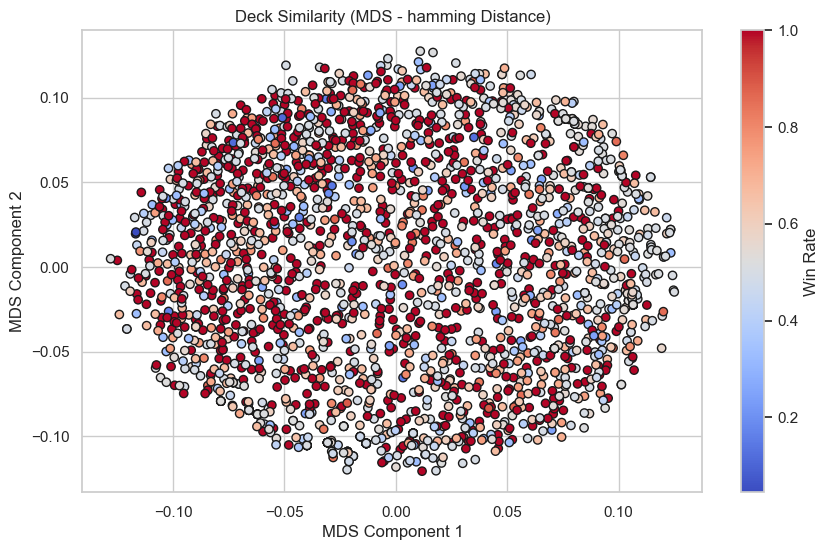

ValueError: Number of columns must be a positive integer, not 0

<Figure size 2000x1200 with 0 Axes>

In [32]:
for metric in metrics:
    # ---- MDS Visualization ----
    plt.figure(figsize=(10, 6))
    sc = plt.scatter((plots_mds[metric])[:, 0], (plots_mds[metric])[:, 1], 
                     c=battles_df_sampled["winner.win_rate"], cmap="coolwarm", edgecolors="k")
    cbar = plt.colorbar(sc)
    cbar.set_label("Win Rate")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title(f"Deck Similarity (MDS - {metric} Distance)")
    plt.savefig(os.path.join(IMG_DIR, f"deck_similarity_mds_{metric}.png"), dpi=300)
    plt.show()
    
fig, axes = plt.subplots(2, len(metrics) // 2, figsize=(20, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sc = axes[i].scatter((plots_mds[metric])[:, 0], (plots_mds[metric])[:, 1], 
                         c=battles_df_sampled["winner.win_rate"], cmap="coolwarm", edgecolors="k")
    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label("Win Rate")
    axes[i].set_xlabel("MDS Component 1")
    axes[i].set_ylabel("MDS Component 2")
    axes[i].set_title(f"Deck Similarity (MDS - {metric} Distance)")

plt.tight_layout()
combined_filepath = os.path.join(IMG_DIR, "deck_similarity_combined.png")
plt.savefig(combined_filepath, dpi=300)
plt.show()

In [21]:
pairwise_dist_hamming = squareform(pdist(deck_vectors, metric="hamming"))
pairwise_dist_cosine = squareform(pdist(deck_vectors, metric="cosine"))

In [23]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
deck_positions_mds_hamming = mds.fit_transform(pairwise_dist_hamming)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
deck_positions_mds_cosine = mds.fit_transform(pairwise_dist_cosine)

Skipping non-numeric feature: winner.card_set


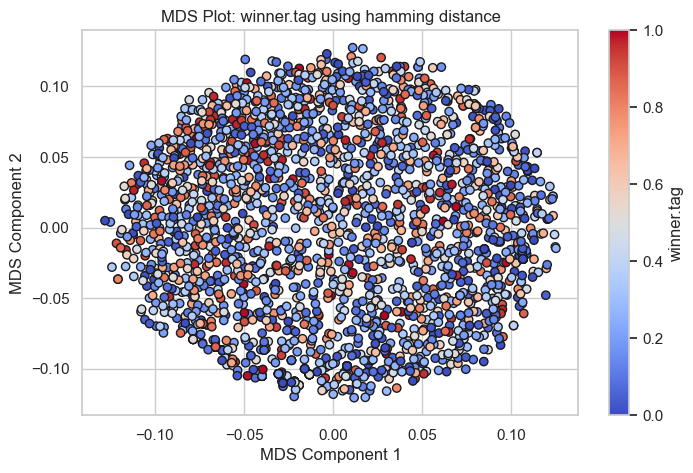

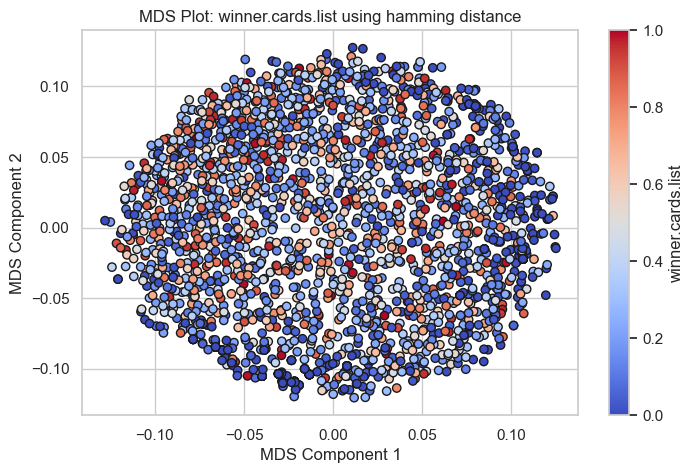

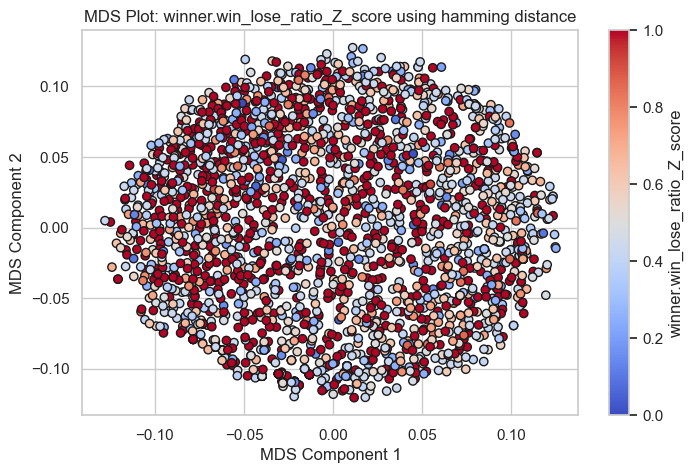

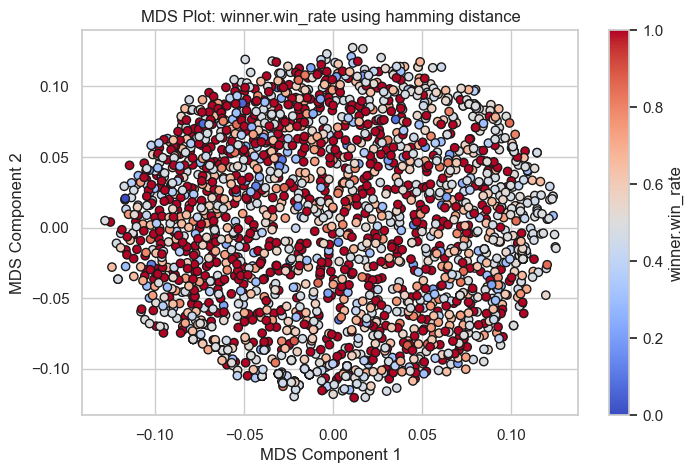

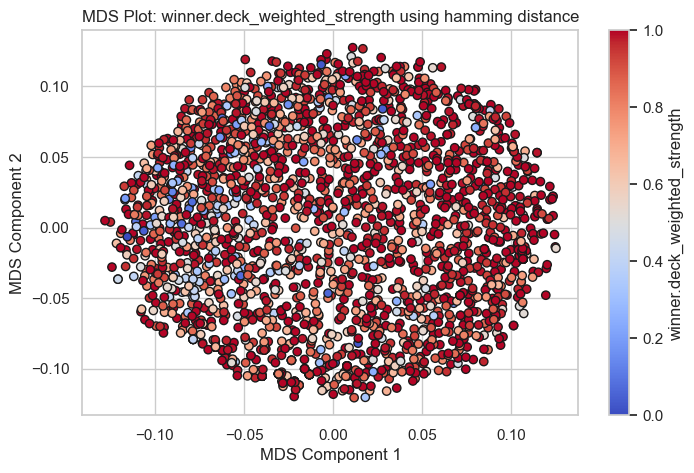

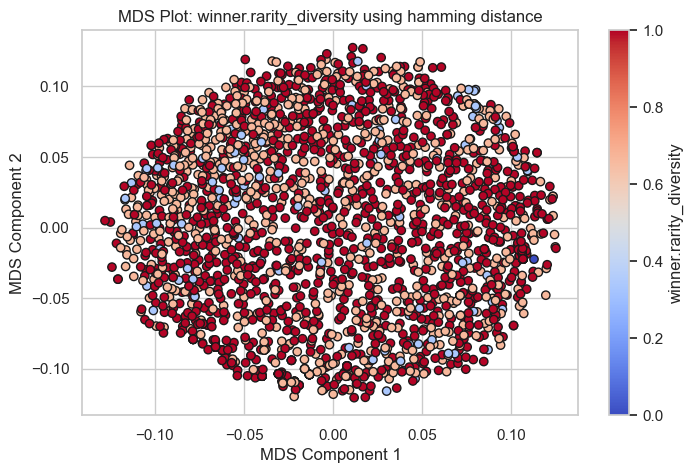

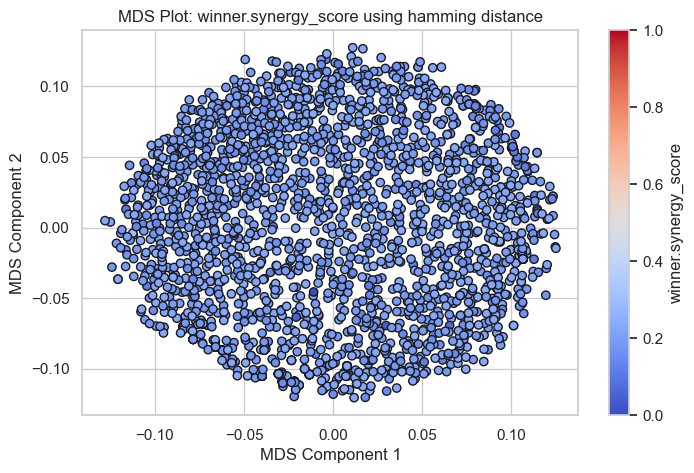

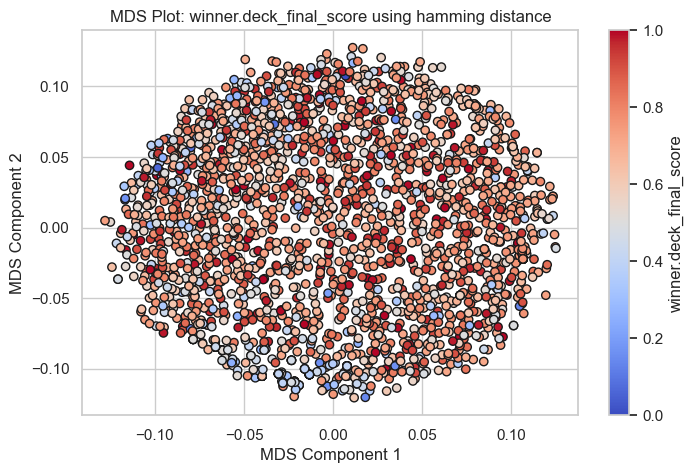

In [27]:
scaler = MinMaxScaler()
# metrics = ["hamming", "cosine"]
metrics = ["hamming"]
first = True
name_to_deck_positions_mapping = {'hamming': deck_positions_mds_hamming, 'cosine': deck_positions_mds_cosine}
for feature in selected_features:
        if pd.api.types.is_numeric_dtype(battles_df_sampled[feature]):
            feature_scaled = scaler.fit_transform(battles_df_sampled[feature].values.reshape(-1, 1))
            for metric in metrics:
                plt.figure(figsize=(8, 5))
                plt.scatter((name_to_deck_positions_mapping[metric])[:, 0], (name_to_deck_positions_mapping[metric])[:, 1], 
                            c=feature_scaled, cmap="coolwarm", edgecolors="k")
                plt.xlabel("MDS Component 1")
                plt.ylabel("MDS Component 2")
                plt.title(f"MDS Plot: {feature} using {metric} distance")
                cbar = plt.colorbar()
                cbar.set_label(feature)
                plt.savefig(os.path.join(IMG_DIR, f"mds_plot_{feature}_{metric}.png"), dpi=300)
                plt.show()
        else:
            print(f"Skipping non-numeric feature: {feature}")

# Summary of metrics

Our analysis of distance metrics indicates that most metrics we experimented with, yield comparable results in distinguishing between data points. Given this similarity, we prioritize the Hamming and Cosine distances due to their computational efficiency when applied to our binary vector representation of card decks. Hamming distance is particularly advantageous in this context, as it simply counts the differing indices between two sparse binary vectors, making it significantly faster than more complex distance metrics. This choice ensures both accurate similarity assessments and computational feasibility, especially given the high-dimensional nature of our dataset.

C:\Users\Saleh\AppData\Local\Temp\ipykernel_22136\2362868552.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mds.tight_layout(rect=[0, 0, 0.9, 1])


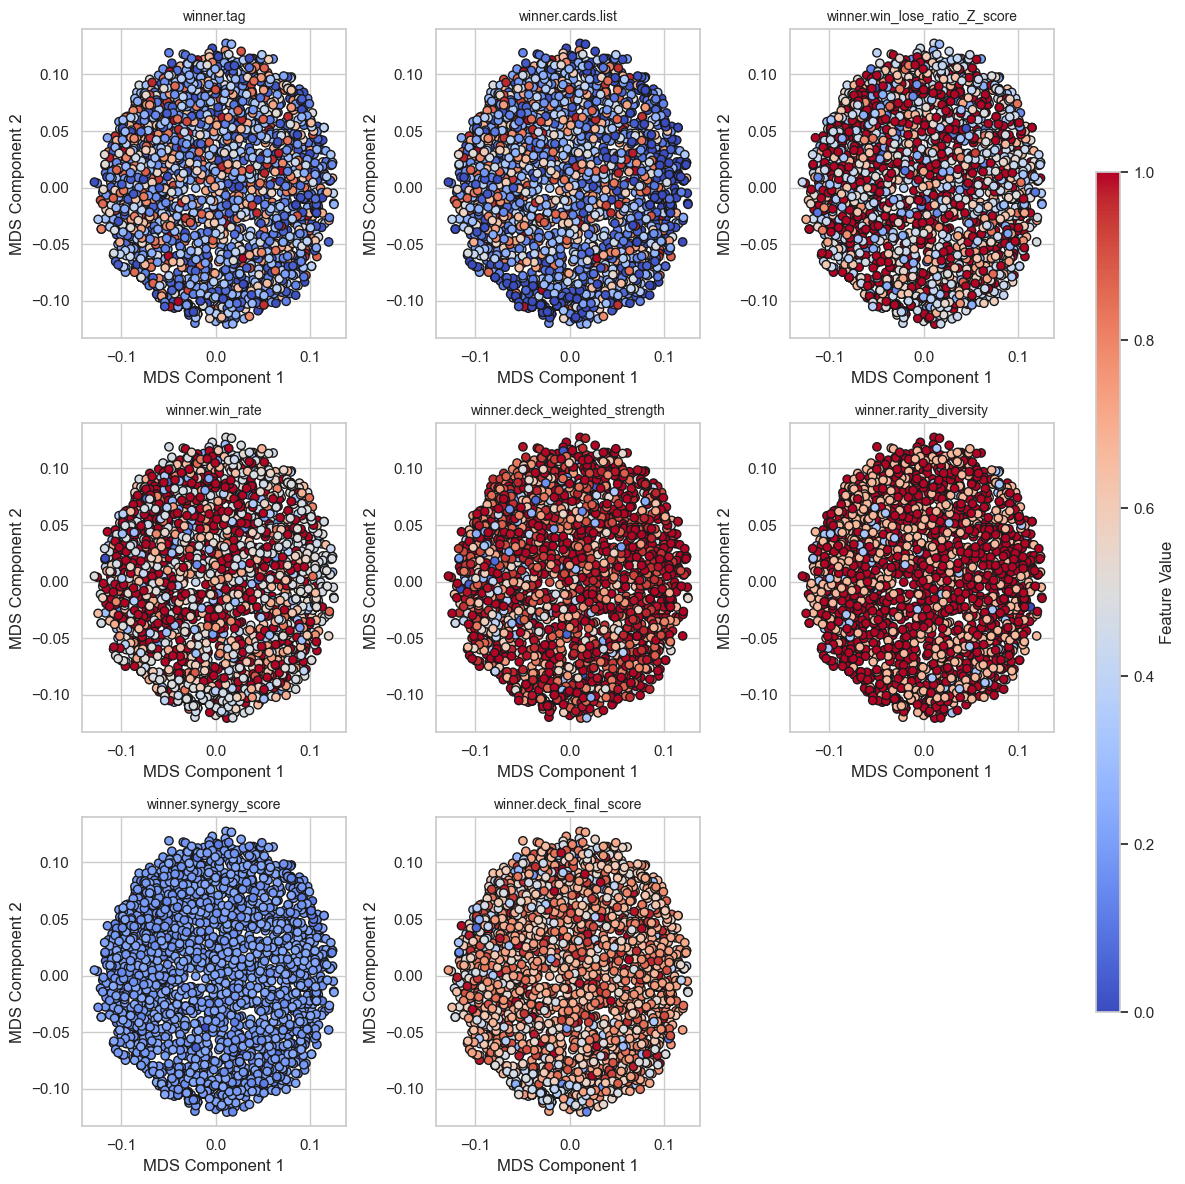

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

scaler = MinMaxScaler()

numeric_features = [f for f in selected_features if pd.api.types.is_numeric_dtype(battles_df_sampled[f])]
n_features = len(numeric_features)

n_cols = int(np.ceil(np.sqrt(n_features)))
n_rows = int(np.ceil(n_features / n_cols))  

fig_mds, axes_mds = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

axes_mds = axes_mds.flatten()
axes_tsne = axes_tsne.flatten()

sc_mds_first = None
sc_tsne_first = None

for i, feature in enumerate(numeric_features):
    feature_scaled = scaler.fit_transform(battles_df_sampled[feature].values.reshape(-1, 1))

    # MDS Plot
    ax_mds = axes_mds[i]
    sc_mds = ax_mds.scatter(deck_positions_mds_hamming[:, 0], deck_positions_mds_hamming[:, 1], 
                            c=feature_scaled, cmap="coolwarm", edgecolors="k")
    ax_mds.set_xlabel("MDS Component 1")
    ax_mds.set_ylabel("MDS Component 2")
    ax_mds.set_title(f"{feature}", fontsize=10)

    if sc_mds_first is None:  
        sc_mds_first = sc_mds

for j in range(i + 1, len(axes_mds)):
    fig_mds.delaxes(axes_mds[j])

fig_mds.subplots_adjust(right=0.9)
cbar_ax_mds = fig_mds.add_axes([0.92, 0.15, 0.02, 0.7])
fig_mds.colorbar(sc_mds_first, cax=cbar_ax_mds, label="Feature Value")

fig_mds.tight_layout(rect=[0, 0, 0.9, 1])
fig_mds.savefig(os.path.join(IMG_DIR,"mds_plots.png"), dpi=300)

plt.show()


# TODO!
- reflect on the outcome of these plots.
- consider changing the sample size calculation to take into account the appearances of decks as to not be influenced by decks that appeared a low number of times?

In [ ]:
deck_appearances = battles_df_sampled_new['winner.card_set'].value_counts()
battles_df_sampled_new['appearances'] = battles_df_sampled_new['winner.card_set'].map(deck_appearances)

print(battles_df_sampled_new.shape)
battles_df_sampled_new.head()

(2171, 10)


winner.card_set  winner.tag  \
372792   (26000011, 26000012, 26000015, 26000017, 26000...      161301   
1041134  (26000005, 26000008, 26000011, 26000012, 26000...      414459   
2016917  (26000004, 26000017, 26000020, 26000045, 26000...      943792   
2376284  (26000006, 26000012, 26000035, 26000044, 26000...     1042757   
2055323  (26000000, 26000026, 26000030, 26000041, 27000...      969243   

         winner.cards.list  winner.win_lose_ratio_Z_score  winner.win_rate  \
372792              147988                       1.243679         1.000000   
1041134             384415                      -0.820336         0.500000   
2016917             852831                       1.243679         1.000000   
2376284             937941                      -0.304332         0.625000   
2055323                110                      -0.820336         0.514995   

         winner.deck_weighted_strength  winner.rarity_diversity  \
372792                        0.886364                        3   
1041134                       1.000000                        3   
2016917                       0.931818                        4   
2376284                       0.965909                        4   
2055323                       0.761364                        4   

         winner.synergy_score  winner.deck_final_score  appearances  
372792               0.611200                 0.899289            1  
1041134              0.611200                 0.779370            1  
2016917              0.622258                 0.760131            1  
2376284              0.629168                 0.747075            1  
2055323              0.607182                 0.668322           34

In [ ]:
# from sklearn.cluster import KMeans

# features = battles_df_ext.columns[1:-1]

# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(battles_df_ext[features])

# kmeans = KMeans(n_clusters=3, random_state=42)
# clusters = kmeans.fit_predict(normalized_features)

# battles_df_ext["cluster_kmeans"] = clusters
# cluster_summary_kmeans = battles_df_ext.groupby("cluster_kmeans")["win_rate_scaled"].mean()

# plt.figure(figsize=(10, 6))
# plt.scatter(battles_df_ext[features[0]], battles_df_ext[features[1]], c=battles_df_ext["cluster_kmeans"], cmap="coolwarm", edgecolors="k")
# plt.xlabel(features[0])
# plt.ylabel(features[1])
# plt.title("K-Means")
# plt.colorbar(label="Cluster")
# plt.show()

# for i in range(len(features)):
#     for j in range(i + 1, len(features)):
#         plt.figure(figsize=(10, 6))
#         plt.scatter(battles_df_ext[features[i]], battles_df_ext[features[j]], c=battles_df_ext["cluster_kmeans"], cmap="coolwarm", edgecolors="k")
#         plt.xlabel(features[i])
#         plt.ylabel(features[j])
#         plt.title(f"K-Means: {features[i]} vs {features[j]}")
#         plt.colorbar(label="Cluster")
#         plt.show()